## Libraries used

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import torch
from sklearn.model_selection import train_test_split

from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
#from gluonts.dataset.util import to_pandas

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

from tqdm import tqdm
from datetime import date
import re
import os
import xlsxwriter

/home/akn/miniconda3/envs/uni/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gold data import from yahoo finance

In [2]:
symbol = 'GC=F'
data = yf.download(symbol, 
                start='2000-12-31', 
                end='2025-04-01', 
                progress=False,
)
df = pd.DataFrame()
df['ReportTime'] = data['Close'].reset_index()['Date']
df['Value'] = data['Close'].reset_index()[symbol]
df['Item_id'] = symbol 

df

YF.download() has changed argument auto_adjust default to True


,ReportTime,Value,Item_id
0,2001-01-02,268.399994,GC=F
1,2001-01-03,268.000000,GC=F
2,2001-01-04,267.299988,GC=F
3,2001-01-05,268.000000,GC=F
4,2001-01-08,268.000000,GC=F
...,...,...,...
6078,2025-03-25,3023.699951,GC=F
6079,2025-03-26,3020.899902,GC=F
6080,2025-03-27,3060.199951,GC=F
6081,2025-03-28,3086.500000,GC=F


In [3]:
def wrangle(data_raw):
    data_index = data_raw[
                    ['Item_id']
                                ].drop_duplicates().reset_index(drop=True)

    data_sheet = pd.DataFrame()
    
    items = {}
    for ind in tqdm(data_index.index, desc="Data wrangle status", total=len(data_index.index)):

        Item_id = data_index['Item_id'][ind]

        df = data_raw.loc[
                (data_raw['Item_id'] == Item_id)
                ]

        data = pd.DataFrame()
        data['Report Time'] = df['ReportTime'].astype('datetime64[ns]')
        data["Value"] = df["Value"].copy()
        data = data.set_index('Report Time')
        data = data.resample("M").mean().ffill()
        data.reset_index(inplace=True)
        data['item_id'] = Item_id
        
        if (data.tail(1)['Report Time']).dt.month.iloc[0] == int(date.today().strftime("%m")):
            data.drop(len(data)-1, inplace=True)

        data_sheet = pd.concat([data_sheet, data])

    return data_sheet, data_index

In [4]:
data, data_index = wrangle(df)#.set_index("Report Time")

data

Data wrangle status:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_60671/1761015033.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample("M").mean().ffill()
Data wrangle status: 100%|██████████| 1/1 [00:00<00:00, 106.77it/s]


,Report Time,Value,item_id
0,2001-01-31,265.371427,GC=F
1,2001-02-28,261.805263,GC=F
2,2001-03-31,262.290907,GC=F
3,2001-04-30,261.079997,GC=F
4,2001-05-31,272.077272,GC=F
...,...,...,...
286,2024-11-30,2649.815015,GC=F
287,2024-12-31,2643.580950,GC=F
288,2025-01-31,2722.947626,GC=F
289,2025-02-28,2897.115800,GC=F


In [5]:
data_index

,Item_id
0,GC=F


## Salesforce - Moirai model

In [6]:
TEST = 12
PDT = 12 # prediction length: any positive integer
CTX = 200  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 1  # batch size: any positive integer

MODEL = "moirai"  # model name: choose from {'moirai', 'moirai-moe'}

SIZE = "large"

In [7]:
def moirai_BT(ds, test_data):
    # Prepare model
    if MODEL == "moirai":
        model = MoiraiForecast(
            module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
            prediction_length=PDT,
            context_length=CTX,
            patch_size=PSZ,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=ds.num_feat_dynamic_real,
            past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
        )
    elif MODEL == "moirai-moe":
        model = MoiraiMoEForecast(
            module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-{SIZE}"),
            prediction_length=PDT,
            context_length=CTX,
            patch_size=16,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=ds.num_feat_dynamic_real,
            past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
        )

    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)

    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)

    return forecast_it 

In [8]:
def process(train_, target="Value", item_id="item_id", timestamp='Report Time', freq='M'): 

    ds = PandasDataset.from_long_dataframe(train_, target=target, item_id=item_id, timestamp=timestamp, freq=freq)

    # Split into train/test set & assign last TEST time steps as test set
    train, test_template = split(ds, offset=-TEST)
    
    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
    )

    forecast_it = moirai_BT(ds, test_data)

    return forecast_it

## Function definitions for result reporting

In [9]:
def mape(predictions):

    grouped = predictions.groupby('item_id')['MAPE'].agg(["mean", "std"])

    predictions = predictions.merge(grouped, on='item_id', suffixes=('', '_agg'))

    mape_list = grouped['mean'].tolist()
    std_list = grouped['std'].tolist()

    return predictions, mape_list, std_list

In [10]:
def result(forecast_it, train_df):
    all_preds = list()
    for item in forecast_it:
        
        family = item.item_id
        p = item.samples.mean(axis=0)
        p10 = np.percentile(item.samples, 10, axis=0)
        p90 = np.percentile(item.samples, 90, axis=0)
        dates = pd.date_range(start=item.start_date.to_timestamp(), periods=len(p), freq='ME')
        family_pred = pd.DataFrame({'Report Time': dates, 'item_id': family, 'Forecast': p, 'p10': p10, 'p90': p90})
        all_preds += [family_pred]

    all_preds = pd.concat(all_preds, ignore_index=True)
    
    all_preds = all_preds.merge(train_df, on=['Report Time', 'item_id'], how='left')

    all_preds["MAPE"] = abs( (all_preds['Value'] - all_preds['Forecast']) / all_preds['Value'] ) * 100

    result, mape_list, std_list = mape(all_preds)

    return result, mape_list, std_list

In [11]:
def error_fig(mape_results, mypath):
    mean = float(round((mape_results).mean(), 2))
    std = float(round(np.std(mape_results), 2))

    # Plotting the line plot using matplotlib
    plt.figure(figsize=(11.86, 3.6))
    plt.plot(mape_results, marker='o')
    plt.title(f"Overall Mean={mean} & std deviation={std} of MAPEs for 2year BT")
    plt.xlabel('Period')
    plt.ylabel('MAPE')
    plt.grid(True)

    # Saving the plot as an image without displaying it
    plt.savefig(f"{mypath}_mape.png", dpi=200)

    return mean, std

## Train-test split

In [12]:
# Perform train-test split for each item_id
train_list = []
test_list = []

for item_id in data['item_id'].unique():
    item_df = data[data['item_id'] == item_id]
    train_df, test_df = train_test_split(item_df, test_size=13, shuffle=False)
    train_list.append(train_df)
    test_list.append(test_df)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

## Model Backtesting

In [13]:
path = "/mnt/d/BT/uni2ts/Gold"

workbook = xlsxwriter.Workbook(f"{path}/Results.xlsx")
workbook.close()

unique_dates = test_df['Report Time'].unique()
len(unique_dates)

Mape_dic= {}
Std_dic = {}

i=1
for date in unique_dates:
    
    rows_to_append = test_df[test_df['Report Time'] == date]
    train_df = pd.concat([train_df, rows_to_append])
    test_df = test_df.drop(rows_to_append.index)

    forecast_it = process(train_df.copy())
    Result, Mape_dic[i], Std_dic[i] = result(forecast_it, train_df.copy())#.set_index('Report Time'))

    with pd.ExcelWriter(f"{path}/Results.xlsx", mode="a", engine="openpyxl") as writer:
        Result.to_excel(writer, sheet_name=f'{i}', index=False)

    i+=1

## Result in teams of MAPE

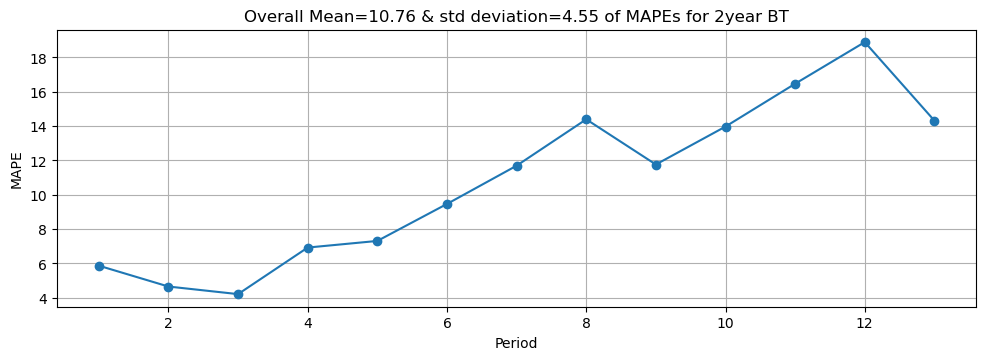

In [14]:
dic = {
    'Item':[],
    'Avg. MAPE':[],
    'Std.Dev. of Avg. MAPE':[],
       }
BTinfo = pd.DataFrame(dic)

mape_df = pd.DataFrame(Mape_dic, index=data['item_id'].unique()).transpose()
os.makedirs(f'{path}/mape_images', exist_ok=True)

for ind in data_index.index:
#for item in data['item_id'].unique():
    item = data_index['Item_id'][ind]
    mypath = f'{path}/mape_images/{item}'
    mean, std = error_fig(mape_df[item], mypath)
    
    bt_list = []
    bt_list.insert(0, data_index['Item_id'][ind])
    bt_list.insert(1, mean)
    bt_list.insert(2, std)
        
    BTinfo.loc[ind] = bt_list
    
BTinfo.to_excel(f'{path}/BTinfo.xlsx', index=False)